# Bitcoin Price Prediction with TimeGPT

This notebook demonstrates:
1. Downloading Bitcoin historical data from Yahoo Finance
2. Using TimeGPT AI model for price forecasting
3. Generating trading signals
4. Backtesting with Backtrader
5. Performance analysis and visualization

## Step 1: Install Required Libraries

In [1]:
# Install required packages
!pip install nixtla backtrader yfinance matplotlib -q

## Step 2: Download Bitcoin Historical Data

In [2]:
import yfinance as yf
import pandas as pd

# Download historical Bitcoin data for BTC-USD (last 5 years)
ticker = "BTC-USD"
btc_data = yf.download(ticker, period="5y")

# Reset index to make 'Date' a column
btc_data = btc_data.reset_index()

# Select 'Date' and 'Close' columns and rename them to 'ds' and 'y' for Nixtla TimeGPT
df_nixtla = btc_data[['Date', 'Close']].copy()
df_nixtla.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Save the data to bitcoin_history.csv
df_nixtla.to_csv('bitcoin_history.csv', index=False)

print("bitcoin_history.csv created successfully from yfinance data!")
print(f"Total records: {len(df_nixtla)}")
print("\nFirst few rows:")
print(df_nixtla.head())

[*********************100%***********************]  1 of 1 completed

bitcoin_history.csv created successfully from yfinance data!
Total records: 1827

First few rows:
Price          ds             y
Ticker                  BTC-USD
0      2021-01-06  36824.363281
1      2021-01-07  39371.042969
2      2021-01-08  40797.609375
3      2021-01-09  40254.546875
4      2021-01-10  38356.441406


## Step 3: Initialize TimeGPT Client

In [3]:
from nixtla import NixtlaClient

# ตั้งค่า API Key และ Initialize Client
# นิสิตสามารถรับ API Key ได้ที่ dashboard.nixtla.io
nixtla_client = NixtlaClient(
    api_key='nixak-HfT2LCTIWXeGkkW3RjPOMu0ok7vmfOZVIEuF6cPOujVLpuEnhxhfPtGPJWlG7ZtXMc4NIocE2PppKHqO'
)

print("TimeGPT client initialized successfully!")

TimeGPT client initialized successfully!


## Step 4: Prepare Data for TimeGPT

In [4]:
# โหลดข้อมูลราคาในอดีต (ตัวอย่างข้อมูลจาก Yahoo Finance หรือ CSV)
# ข้อมูลต้องมีคอลัมน์ 'ds' (วันที่) และ 'y' (ราคา) ตามมาตรฐานของโมเดล
df = pd.read_csv('bitcoin_history.csv')
df['ds'] = pd.to_datetime(df['ds'])

# Fix: Convert 'y' column to numeric and remove non-numeric rows
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df.dropna(subset=['y'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Data prepared successfully!")
print(f"Clean records: {len(df)}")
print("\nData summary:")
print(df.describe())

Data prepared successfully!
Clean records: 1827

Data summary:
                        ds              y
count                 1827    1827.000000
mean   2023-07-08 00:00:00   54608.999780
min    2021-01-06 00:00:00   15787.284180
25%    2022-04-07 12:00:00   29412.204102
50%    2023-07-08 00:00:00   46627.777344
75%    2024-10-06 12:00:00   69361.058594
max    2026-01-06 00:00:00  124752.531250
std                    NaN   29508.173716


## Step 5: Generate 30-Day Price Forecast with TimeGPT

In [5]:
# เรียกใช้ TimeGPT เพื่อพยากรณ์ราคา (Zero-Shot Forecasting)
# h = 30 คือการพยากรณ์ล่วงหน้า 30 วัน
print("Generating forecast with TimeGPT...")
forecast_df_raw = nixtla_client.forecast(
    df=df, 
    h=30, 
    time_col='ds', 
    target_col='y'
)

print("\nForecast generated successfully!")
print("\nForecast data:")
print(forecast_df_raw.head())

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


Generating forecast with TimeGPT...


INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...



Forecast generated successfully!

Forecast data:
          ds   TimeGPT
0 2026-01-07  93667.59
1 2026-01-08  93195.92
2 2026-01-09  93357.20
3 2026-01-10  93375.91
4 2026-01-11  93001.64


## Step 6: Generate Trading Signals

In [6]:
# สร้าง "Predicted Signal" (ตัวอย่าง: ถ้าคาดการณ์ว่าพรุ่งนี้ราคาสูงกว่าวันนี้ ให้เป็น 1)
# เพื่อแก้ไข KeyError: 'y', เราจำเป็นต้องสร้าง series ของราคาที่ต่อเนื่องทั้งข้อมูลจริงและข้อมูลพยากรณ์
# เพื่อใช้ในการเปรียบเทียบกับค่าก่อนหน้า

# รวมค่า y (จาก df) และ TimeGPT (จาก forecast_df_raw) เข้าด้วยกัน
# เพื่อให้มี Series ราคาต่อเนื่องในการคำนวณการเลื่อน (shift)
all_y_values = pd.concat([df['y'], forecast_df_raw['TimeGPT']], ignore_index=True)

# สร้าง forecast_df ที่จะใช้บันทึกผลลัพธ์
forecast_df = forecast_df_raw.copy()

# คำนวณ 'predicted_signal' โดยการเปรียบเทียบค่าพยากรณ์ปัจจุบันกับค่าก่อนหน้า
# ค่าก่อนหน้าสำหรับจุดพยากรณ์แรกคือราคาจริงสุดท้ายจาก df
# ค่าก่อนหน้าสำหรับจุดพยากรณ์ถัดไปคือค่าพยากรณ์ของวันก่อนหน้า
forecast_df['predicted_signal'] = (
    forecast_df['TimeGPT'] > all_y_values.shift(1).iloc[len(df):].reset_index(drop=True)
).astype(float)

# บันทึกเป็นไฟล์ CSV เพื่อนำไปใช้ใน Backtrader Lab
forecast_df.to_csv('bitcoin_predictions.csv', index=False)
print("ไฟล์ bitcoin_predictions.csv ถูกสร้างเรียบร้อยแล้ว!")
print("\nTrading Signals:")
print(forecast_df[['ds', 'TimeGPT', 'predicted_signal']])

ไฟล์ bitcoin_predictions.csv ถูกสร้างเรียบร้อยแล้ว!

Trading Signals:
           ds    TimeGPT  predicted_signal
0  2026-01-07  93667.590               0.0
1  2026-01-08  93195.920               0.0
2  2026-01-09  93357.200               1.0
3  2026-01-10  93375.910               1.0
4  2026-01-11  93001.640               0.0
5  2026-01-12  92788.480               0.0
6  2026-01-13  92697.840               0.0
7  2026-01-14  92552.870               0.0
8  2026-01-15  92351.450               0.0
9  2026-01-16  92650.555               1.0
10 2026-01-17  92746.010               1.0
11 2026-01-18  92659.305               0.0
12 2026-01-19  92550.640               0.0
13 2026-01-20  92462.470               0.0
14 2026-01-21  92434.530               0.0
15 2026-01-22  92359.760               0.0
16 2026-01-23  92465.914               1.0
17 2026-01-24  92507.640               1.0
18 2026-01-25  92403.190               0.0
19 2026-01-26  92330.510               0.0
20 2026-01-27  92293.300   

## Step 7: Verify Data Quality

In [7]:
# Load the problematic DataFrame for inspection
df_problematic = pd.read_csv('bitcoin_history.csv')

print("Original 'y' column data type before conversion:", df_problematic['y'].dtype)
print("First few values of 'y' column before conversion:")
print(df_problematic['y'].head())

# Apply the fix: Convert 'y' to numeric, coercing errors, then drop NaNs
df_problematic['y'] = pd.to_numeric(df_problematic['y'], errors='coerce')
df_cleaned = df_problematic.dropna(subset=['y']).reset_index(drop=True)
df_cleaned['ds'] = pd.to_datetime(df_cleaned['ds'])  # Also ensure 'ds' is datetime for consistency

print("\nCleaned 'y' column data type after conversion:", df_cleaned['y'].dtype)
print("First few values of cleaned 'y' column after conversion:")
print(df_cleaned['y'].head())

print("\n✅ Data quality verified!")

Original 'y' column data type before conversion: object
First few values of 'y' column before conversion:
0           BTC-USD
1    36824.36328125
2    39371.04296875
3      40797.609375
4      40254.546875
Name: y, dtype: object

Cleaned 'y' column data type after conversion: float64
First few values of cleaned 'y' column after conversion:
0    36824.363281
1    39371.042969
2    40797.609375
3    40254.546875
4    38356.441406
Name: y, dtype: float64

✅ Data quality verified!


## Step 8: Setup Backtrader for Backtesting

In [8]:
import backtrader as bt

# Define a custom data feed to handle the 'predicted_signal' column
class GenericCSV_Signal(bt.feeds.GenericCSVData):
    lines = ('predicted_signal',)
    params = (('predicted_signal', 2),)

# นิยามกลยุทธ์ (Trading Strategy)
class MLStrategy(bt.Strategy):
    params = (('threshold', 0.8),)  # Buy threshold
    
    def __init__(self):
        self.signal = self.datas[0].predicted_signal
        self.order = None
    
    def next(self):
        # If we don't have a position
        if not self.position:
            # Buy signal: predicted_signal > threshold
            if self.signal[0] > self.params.threshold:
                self.buy()
        else:
            # Sell signal: predicted_signal < 0.4
            if self.signal[0] < 0.4:
                self.close()

print("Trading strategy defined successfully!")

Trading strategy defined successfully!


## Step 9: Run Backtest

In [9]:
# ตั้งค่าการรันระบบ (Cerebro - The Brain)
cerebro = bt.Cerebro()

# เพิ่มข้อมูล (Data Feed) using the custom class
data = GenericCSV_Signal(
    dataname='bitcoin_predictions.csv',
    dtformat='%Y-%m-%d',
    datetime=0,         # 'ds' column is at index 0
    close=1,            # 'TimeGPT' column is at index 1
    open=1,             # Use 'TimeGPT' for open
    high=1,             # Use 'TimeGPT' for high
    low=1,              # Use 'TimeGPT' for low
    volume=-1,          # No volume
    openinterest=-1,    # No open interest
    predicted_signal=2  # 'predicted_signal' is at index 2
)
cerebro.adddata(data)

# ใส่กลยุทธ์และเงินทุนเริ่มต้น
cerebro.addstrategy(MLStrategy)
cerebro.broker.setcash(100000.0)

# เพิ่มตัววิเคราะห์ประสิทธิภาพ (Performance Metrics)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

print(f"Starting Portfolio Value: ${cerebro.broker.getvalue():,.2f}")

# รัน Backtest
results = cerebro.run()

print(f"Final Portfolio Value: ${cerebro.broker.getvalue():,.2f}")

Starting Portfolio Value: $100,000.00
Final Portfolio Value: $98,904.65


## Step 10: Analyze Performance Results

In [10]:
# แสดงผลลัพธ์ (Analyzing Results)
sharpe_ratio = results[0].analyzers.sharpe.get_analysis()['sharperatio']
max_drawdown = results[0].analyzers.drawdown.get_analysis()['max']['drawdown']

print("\n" + "="*50)
print("BACKTEST PERFORMANCE SUMMARY")
print("="*50)
print(f"Sharpe Ratio: {sharpe_ratio if sharpe_ratio else 'N/A'}")
print(f"Max Drawdown: {max_drawdown:.2f}%")
print("="*50)


BACKTEST PERFORMANCE SUMMARY
Sharpe Ratio: N/A
Max Drawdown: 1.10%


## Step 11: Visualize Backtest Results

In [11]:
# Plot backtest results
# Fix: Disable volume plotting to avoid ValueError
cerebro.plot(volume=False)

<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 3 Axes>]]

## Step 12: Visualize Price Predictions

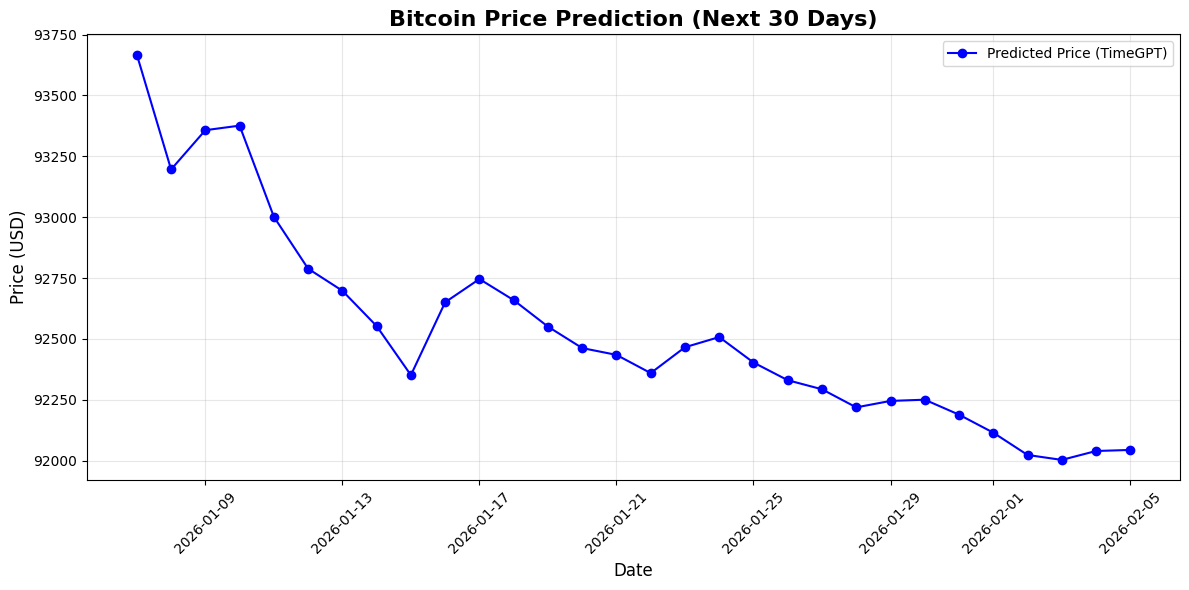


📊 Prediction chart displayed successfully!


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# Load the predictions
df_preds = pd.read_csv('bitcoin_predictions.csv')
df_preds['ds'] = pd.to_datetime(df_preds['ds'])

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(
    df_preds['ds'], 
    df_preds['TimeGPT'], 
    label='Predicted Price (TimeGPT)', 
    color='blue', 
    marker='o'
)

# Formatting
plt.title('Bitcoin Price Prediction (Next 30 Days)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

print("\n📊 Prediction chart displayed successfully!")